In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
print(len(df_test), len(df_train))

418 891


In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1138a4b70>,
      dtype=object)

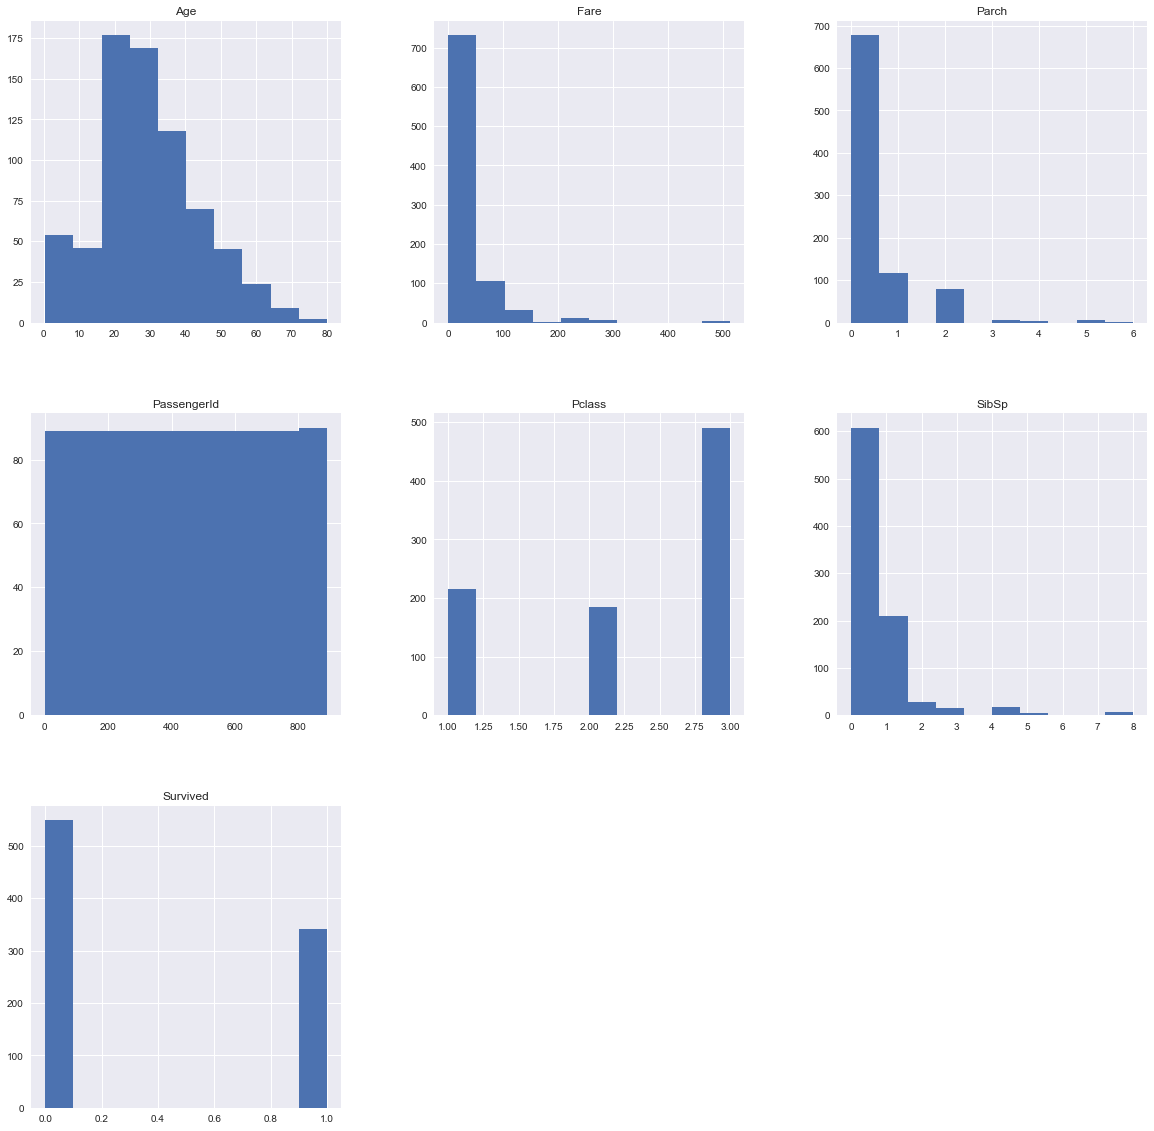

In [7]:
df_train.hist(figsize= (20, 20))

In [8]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
df_full = [df_train, df_test]
df_train['Has_Cabin'] = df_train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df_test['Has_Cabin'] = df_test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [10]:
df_train.loc[df_train['Sex'] == "male", 'Sex'] = 1
df_train.loc[df_train['Sex'] == "female", 'Sex'] = 0
df_test.loc[df_test['Sex'] == "male", 'Sex'] = 1
df_test.loc[df_test['Sex'] == "female", 'Sex'] = 0
    

In [11]:
for dataframe in df_full:
    dataframe['Embarked'] = dataframe['Embarked'].fillna('S')
    dataframe["Embarked"] = dataframe["Embarked"].map( {'S':0, 'C': 1, 'Q': 2}).astype(int)

In [12]:
#borrowing ideas from Kaggler kernals. I liked this one the best rather than just replacing with medians
for dataframe in df_full:
    age_average = dataframe["Age"].mean()
    age_deviation = dataframe["Age"].std()
    age_null_count = dataframe['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_average - age_deviation, age_average + age_deviation, size=age_null_count)
    dataframe['Age'][np.isnan(dataframe['Age'])] = age_null_random_list
    dataframe['Age'] = dataframe['Age'].astype(int)

/Users/jayklein95/anaconda/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
for dataframe in df_full:
    dataframe.loc[ dataframe['Age'] <= 16, 'Age'] = 0
    dataframe.loc[(dataframe['Age'] > 21) & (dataframe['Age'] <= 31), 'Age'] = 1
    dataframe.loc[(dataframe['Age'] > 31) & (dataframe['Age'] <= 41), 'Age'] = 2
    dataframe.loc[(dataframe['Age'] > 41) & (dataframe['Age'] <= 51), 'Age'] = 3
    dataframe.loc[ dataframe['Age'] > 51, 'Age'] = 4 ;

In [14]:
df_train['Age'].isnull().sum()

0

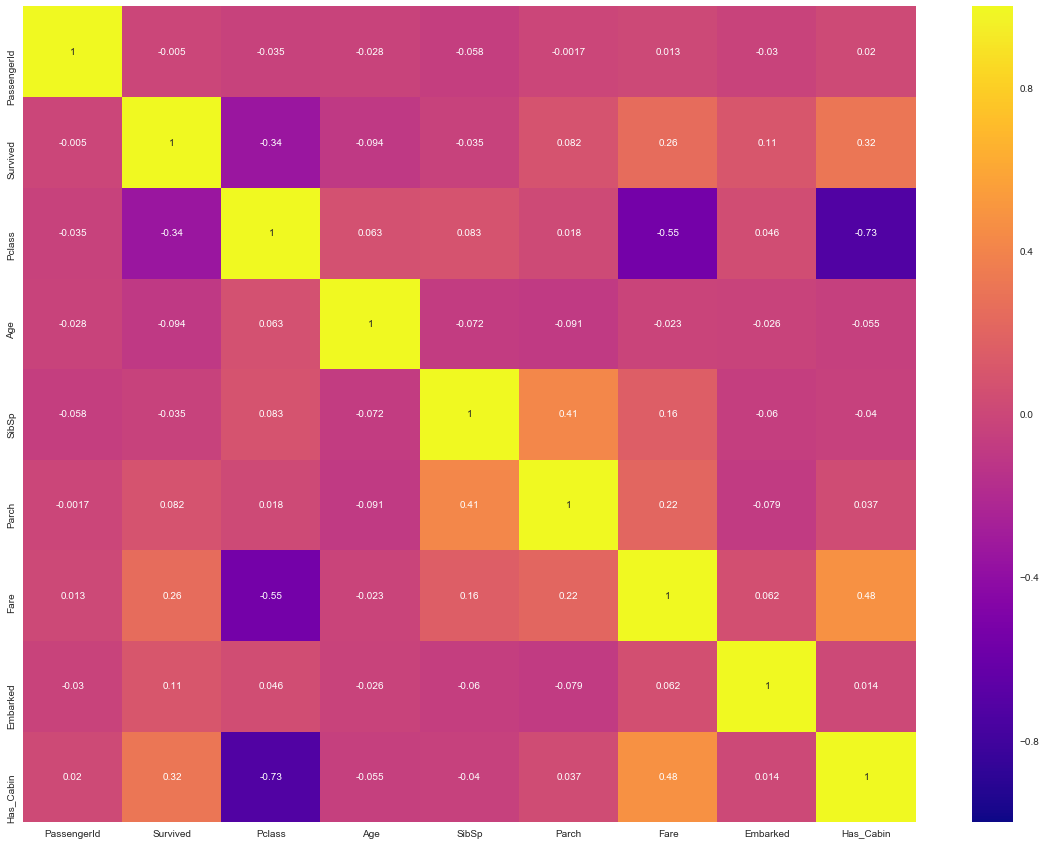

In [15]:
plt.subplots(figsize=(20, 15))
ax = plt.axes()
corr = df_train.corr()

sns.heatmap(corr,
            annot=True,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
          cmap = plt.cm.plasma)

In [16]:
X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Has_Cabin']]
y = df_train['Survived']
target_names = ["survives", "dies"]
feature_names = X.columns

In [17]:
X["Age"].isnull().sum()

0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)
svc = SVC(kernel="linear")

In [19]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:

print('Test Acc: %.3f' % svc.score(X_test, y_test))
MSE_svc = mean_squared_error(y_test, svc.predict(X_test))  
print(f"MSE: {MSE_svc}")

Test Acc: 0.771
MSE: 0.22869955156950672


In [21]:
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

   survives       0.78      0.86      0.82       133
       dies       0.75      0.64      0.69        90

avg / total       0.77      0.77      0.77       223



In [22]:
X_train_lrc, X_test_lrc, y_train_lrc, y_test_lrc = train_test_split(X, y, random_state=32)

In [23]:
lrc = LogisticRegression()

In [24]:
lrc.fit(X_train_lrc, y_train_lrc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
lrc.score(X_test_lrc, y_test_lrc)

0.7713004484304933

In [26]:
predictions = lrc.predict(X_test_lrc)
print(classification_report(y_test_lrc, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

   survives       0.78      0.86      0.82       133
       dies       0.76      0.63      0.69        90

avg / total       0.77      0.77      0.77       223



In [27]:
rf = RandomForestClassifier(n_estimators=400)

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
rf.score(X_test, y_test)

0.7982062780269058

In [30]:
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

   survives       0.82      0.85      0.83       133
       dies       0.76      0.72      0.74        90

avg / total       0.80      0.80      0.80       223



In [31]:
sgc = SGDClassifier()

In [32]:
sgc.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [33]:
sgc.score(X_test, y_test)

0.6412556053811659

In [34]:
predictions = sgc.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

   survives       0.63      0.98      0.76       133
       dies       0.81      0.14      0.25        90

avg / total       0.70      0.64      0.56       223



In [35]:
gbc = GradientBoostingClassifier(loss="deviance", learning_rate=0.01, n_estimators=700)

In [36]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=700, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [37]:
gbc.score(X_test, y_test)

0.8295964125560538

In [38]:
gbc_grid = GradientBoostingClassifier()

In [39]:
from sklearn.model_selection import GridSearchCV
param_grid = {'learning_rate' : [.01, .1, 1.0 ],
             'n_estimators' : [100, 200, 300, 500]}

grid = GridSearchCV(gbc_grid, param_grid, verbose=0)

In [40]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1, 1.0], 'n_estimators': [100, 200, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [41]:
grid.score(X_test, y_test)

0.8026905829596412

In [42]:
vote = VotingClassifier(estimators=[('lr', lrc), ('rf', rf), ('gbc', gbc), ('svc', svc), ('grid', grid)], voting='hard')

In [43]:
vote.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))],
         n_jobs=1, voting='hard', weights=None)

In [44]:
vote.score(X_test, y_test)

/Users/jayklein95/anaconda/envs/PythonData/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8340807174887892

In [45]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,7.8292,NaN,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,0,363272,7.0000,NaN,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,4,0,0,240276,9.6875,NaN,2,0
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,8.6625,NaN,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,12.2875,NaN,0,0


In [46]:
X_df_test = [['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'Has_Cabin']]

In [47]:
df_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age              int64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked         int64
Has_Cabin        int64
dtype: object

In [48]:
df_test = df_test.fillna(0)

In [49]:
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Has_Cabin      0
dtype: int64

In [50]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,7.8292,0,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,0,363272,7.0000,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,4,0,0,240276,9.6875,0,2,0
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,8.6625,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,12.2875,0,0,0
5,897,3,"Svensson, Mr. Johan Cervin",1,0,0,0,7538,9.2250,0,0,0
6,898,3,"Connolly, Miss. Kate",0,1,0,0,330972,7.6292,0,2,0
7,899,2,"Caldwell, Mr. Albert Francis",1,1,1,1,248738,29.0000,0,0,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,18,0,0,2657,7.2292,0,1,0
9,901,3,"Davies, Mr. John Samuel",1,21,2,0,A/4 48871,24.1500,0,0,0


In [51]:
df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'Has_Cabin']]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin
0,3,1,2,0,0,7.8292,2,0
1,3,0,3,1,0,7.0000,0,0
2,2,1,4,0,0,9.6875,2,0
3,3,1,1,0,0,8.6625,0,0
4,3,0,1,1,1,12.2875,0,0
5,3,1,0,0,0,9.2250,0,0
6,3,0,1,0,0,7.6292,2,0
7,2,1,1,1,1,29.0000,0,0
8,3,0,18,0,0,7.2292,1,0
9,3,1,21,2,0,24.1500,0,0


In [53]:
df_test["survived"] = vote.predict(df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'Has_Cabin']])

/Users/jayklein95/anaconda/envs/PythonData/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,survived
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,7.8292,0,2,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,0,363272,7.0000,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,4,0,0,240276,9.6875,0,2,0,0
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,8.6625,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,12.2875,0,0,0,0


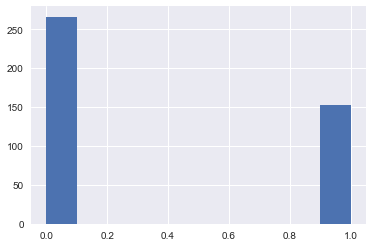

In [55]:
df_test['survived'].hist()

In [57]:
submission_needed = df_test[['PassengerId', 'survived']]
submission_needed.to_csv("submission.csv", index=False)